In [ ]:
import os
import cv2
import keras
import joblib
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import os
from tqdm.contrib.concurrent import process_map
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3, DenseNet121, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Model
import shutil
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


### Definitions

In [ ]:
METHOD = 'agglomerative' # Options are 'hdbscan' or kmeans
NUM_CLUSTERS = 15 # Hand picked
MODEL = "AutoEncoder"
INPUT_SHAPE = (128, 128, 3)
IMAGE_PATH = "/content/drive/My Drive/Investigacion/UTN/GIAR/Dataset/cropped_cells_original"
MODEL_PATH = "../../models"
output_path_dataset = f"/content/drive/My Drive/Investigacion/UTN/GIAR/Dataset/clustering/{MODEL}_{METHOD}_v0"

### Functions

In [ ]:
def get_relative_file_paths(folder_path):

    """
    Gets a list of relative paths to all files within a given folder.

    Args:
        folder_path (str): The path to the folder.

    Returns:
        list: A list of relative file paths.
    """

    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
    return file_paths

def load_image (x):
    if MODEL == "AutoEncoder":
        return cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    else:
        return cv2.imread(x)

### Encoder definition

In [ ]:
if MODEL == "AutoEncoder":
    ENCODER_PATH = "/content/drive/My Drive/Investigacion/UTN/GIAR/Results/Autoencoder/encoder_SSIM_MAE_Bparams.keras"
    encoder = keras.saving.load_model(ENCODER_PATH)
else:
    # Load pre-trained models
    if MODEL == 'VGG16':
        preprocess_input = keras.applications.vgg16.preprocess_input
        encoder = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    elif MODEL == 'VGG19':
        preprocess_input = keras.applications.vgg19.preprocess_input
        VGG19(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    elif MODEL == 'ResNet50':
        preprocess_input = tf.keras.layers.Identity
        ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    elif MODEL == 'InceptionV3':
        preprocess_input = keras.applications.inception_v3.preprocess_input
        InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    elif MODEL == 'DenseNet121':
        preprocess_input = tf.keras.layers.Identity
        DenseNet121(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    elif MODEL == 'MobileNetV2':
        preprocess_input = tf.keras.layers.Identity
        MobileNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

    inp = keras.Input(shape=INPUT_SHAPE)
    x = preprocess_input(inp)
    x = encoder(x)
    x = Flatten()(x)
    encoder = Model(inputs=inp, outputs=x)

In [31]:
encoder.output_shape

(None, 32)

# Load the images

In [ ]:
image_paths = sorted(get_relative_file_paths(IMAGE_PATH))

images = process_map(
                load_image,
                image_paths,
                total=len(image_paths),
                max_workers=16,
                chunksize=32,
            )

  0%|          | 0/53652 [00:00<?, ?it/s]

### Generate encoder embeddings

In [36]:
#Transform input images for encoder input
resized_images = [cv2.resize(image, INPUT_SHAPE[0:2]) for image in images]
resized_images = np.array(resized_images)

# images = images/255 # Esto esta incluido en el modelo

#resized_images = [np.expand_dims(image, axis=(0, -1)) for image in resized_images]

In [37]:
if MODEL == "AutoEncoder":
    resized_images = resized_images / 255.0
    resized_images = np.expand_dims(resized_images, axis=-1)
resized_images.shape

(53652, 128, 128, 1)

In [38]:
encoder.output_shape

(None, 32)

In [39]:
# Extract features from encoder


enc_features_array = np.zeros((resized_images.shape[0], encoder.output_shape[-1]))

batch_size = 256
ini = 0
while True:
    start = ini*batch_size
    end = start+batch_size

    if start >= resized_images.shape[0]:
        break

    if end >= resized_images.shape[0]:
        end = resized_images.shape[0]-1


    this_batch = resized_images[start:end]

    enc_features_array[start:end] = encoder.predict(this_batch, verbose=0)

    ini += 1



In [40]:
# enc_features_array_norm = [a / (np.linalg.norm(a) + 1e-16) for a in enc_features_array]
enc_features_array_norm = enc_features_array


### Train clustering

In [41]:
if METHOD == 'kmeans':
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
    kmeans.fit(enc_features_array_norm)

    centroids = kmeans.cluster_centers_
    seleccted_class = -np.ones((len(enc_features_array_norm)), dtype=int)
    for idx, feature in enumerate(enc_features_array_norm):
        dist = 1e99
        for cluster in range(NUM_CLUSTERS):
            t_dist = np.linalg.norm(feature - centroids[cluster])
            if dist > t_dist:
                dist = t_dist
                seleccted_class[idx] = cluster




In [43]:
if METHOD == 'agglomerative':
    from sklearn.cluster import AgglomerativeClustering

    # Aca si o si normalizamos
    enc_features_array_norm = [a / (np.linalg.norm(a) + 1e-16) for a in enc_features_array]

    # ag_clustering = AgglomerativeClustering
    #     n_clusters = None,
    #     metric = 'euclidean',
    #     linkage = 'ward',
    #     distance_threshold = 1.0,
    #     compute_full_tree = True,
    # )

    ag_clustering = AgglomerativeClustering(
        n_clusters = NUM_CLUSTERS,
        linkage = 'ward',
    )

    clustering = ag_clustering.fit(enc_features_array_norm)
    seleccted_class = clustering.labels_

In [44]:
if METHOD == 'hdbscan':
    from sklearn.cluster import HDBSCAN
    hdb = HDBSCAN()
    clustering = hdb.fit(enc_features_array_norm)
    seleccted_class = clustering.labels_

In [ ]:
joblib.dump(clustering, os.path.join("", 'clustering_model.pkl'))

### Create datasets

In [46]:
# if not os.path.exists('./output/noise'):
#     os.makedirs('./output/noise')

# if not os.path.exists('./output/cells'):
#     os.makedirs('./output/cells')

#### Get cluster representatrives

In [ ]:
NUM_CLUSTERS = len(np.unique(seleccted_class))
GRID_SIZE = 8
NUM_SHOW = GRID_SIZE*GRID_SIZE

rep_images =[[] for _ in range(NUM_CLUSTERS)]
for cluster in range(NUM_CLUSTERS):
    for idx, label in enumerate(seleccted_class):
        if label >= 0:
            if len(rep_images[label]) < NUM_SHOW:
                rep_images[label].append(resized_images[idx])
                # if label == 1:
                #     print(idx, label)

0 64
1 64
2 64
3 64
4 64
5 64
6 64
7 64
8 64
9 64
10 64
11 64
12 64
13 64
14 64


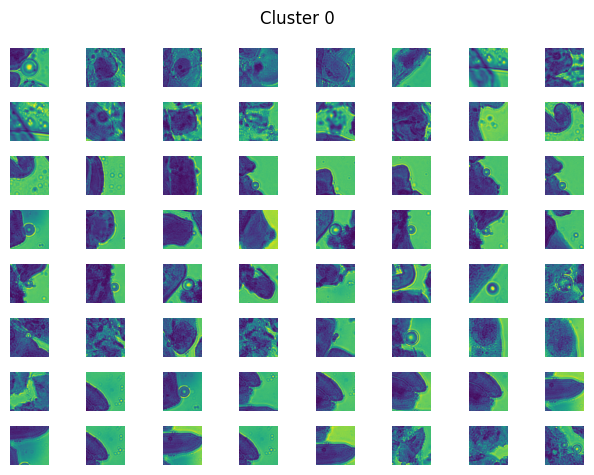

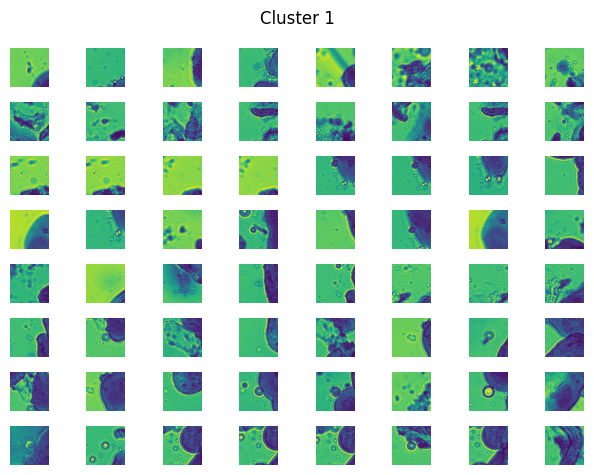

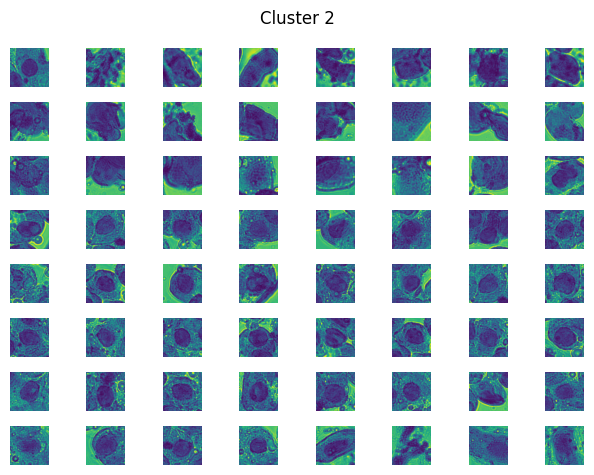

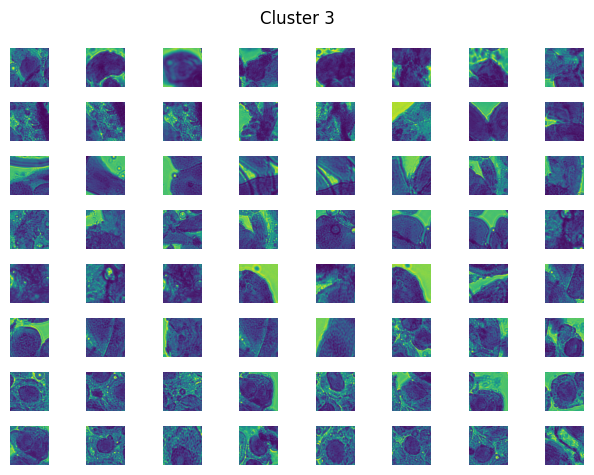

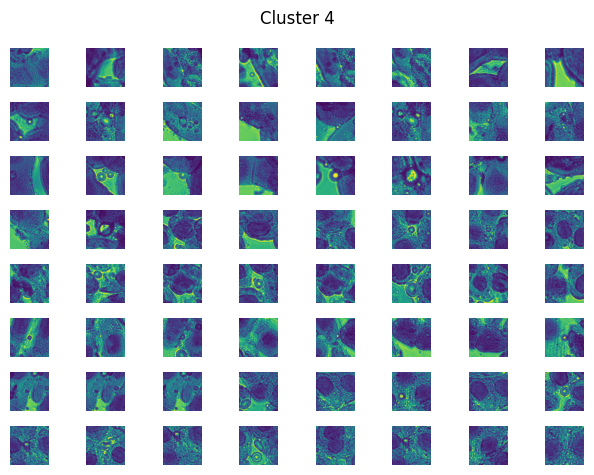

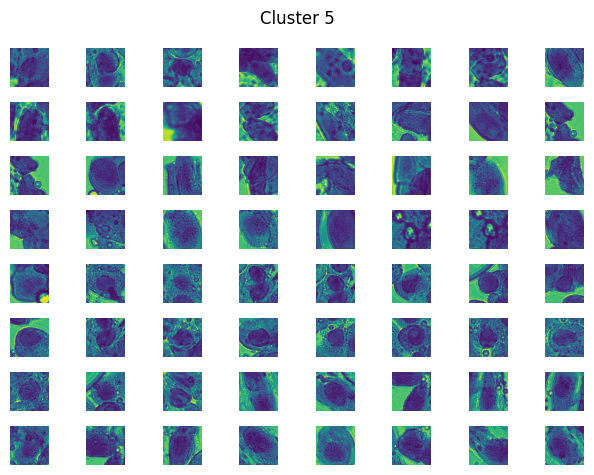

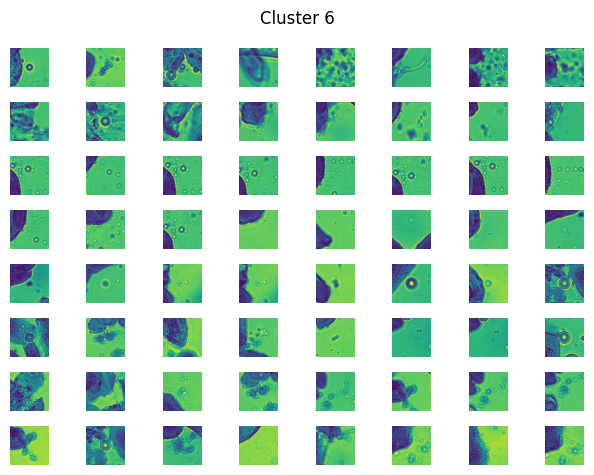

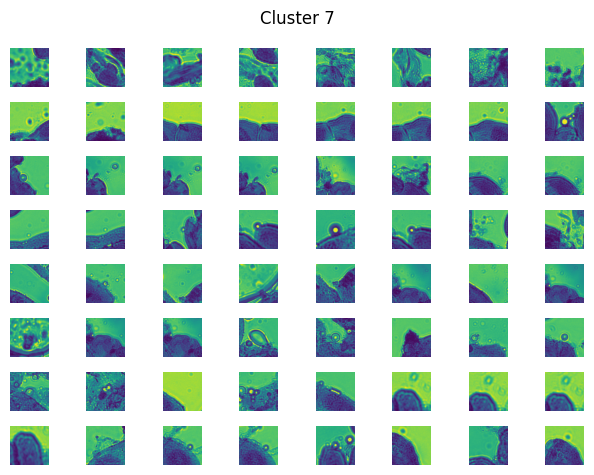

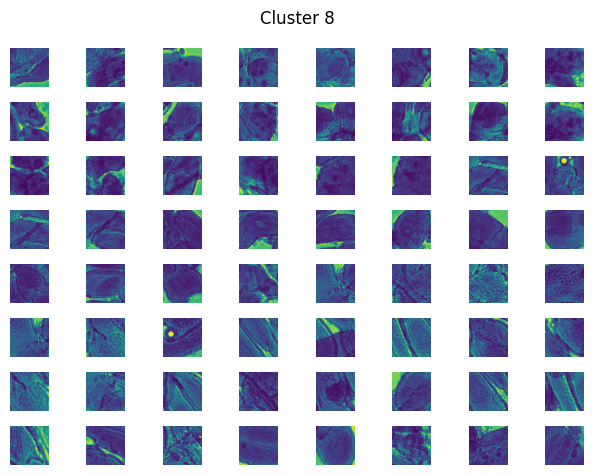

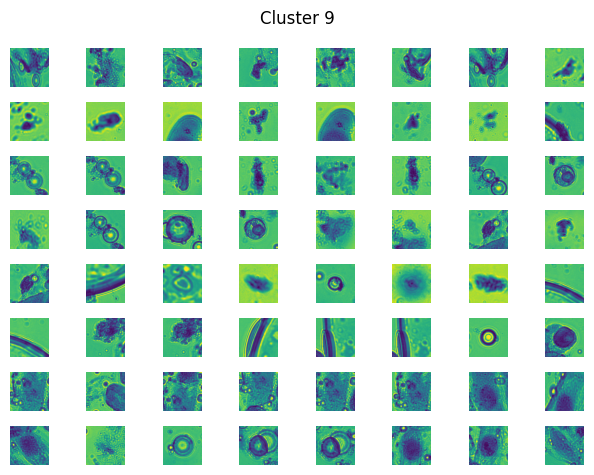

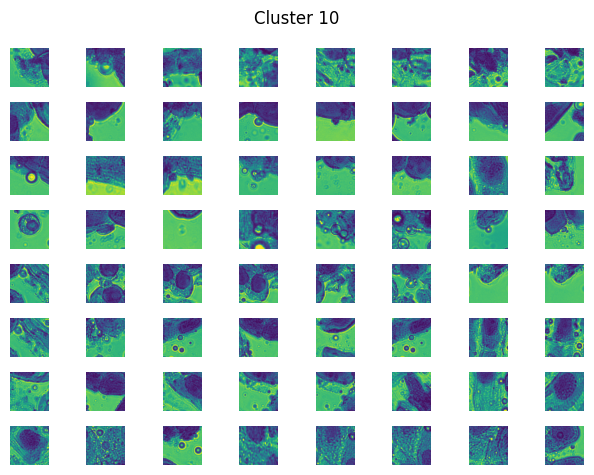

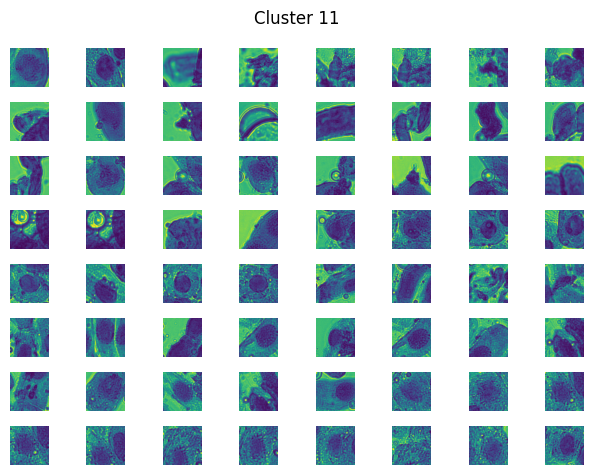

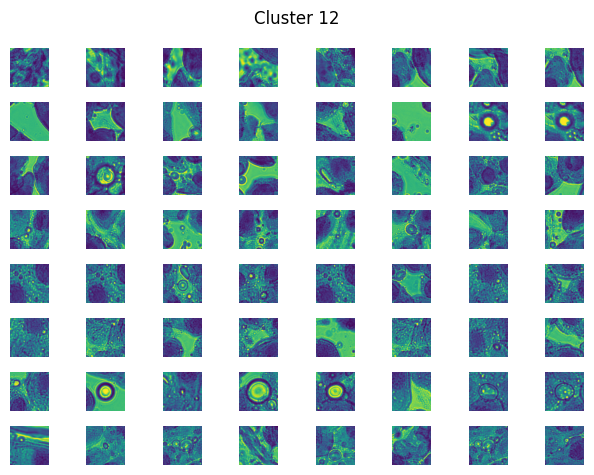

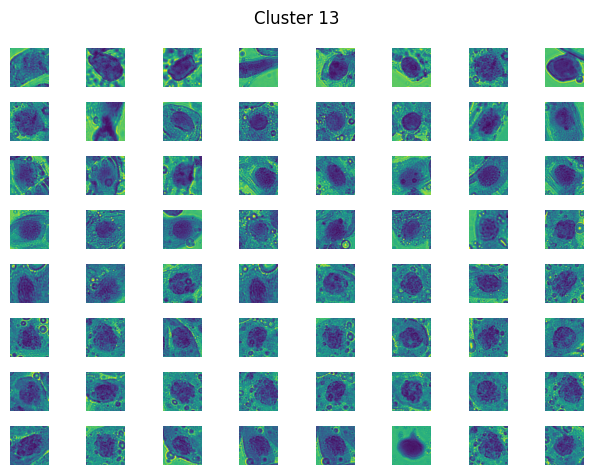

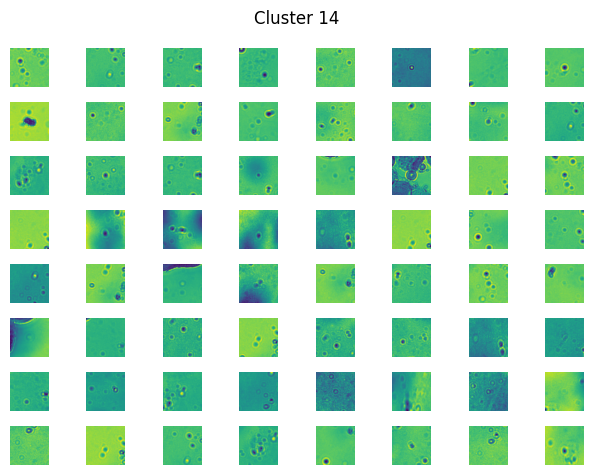

In [48]:

for rep_idx, rep_list in enumerate(rep_images):

    plt.figure()
    n = 1
    for image in rep_list:
        plt.subplot(GRID_SIZE,GRID_SIZE,n)
        plt.imshow(image)
        plt.axis(False)
        n+=1
    plt.suptitle(f"Cluster {rep_idx}")
    plt.tight_layout()

    plt.show()


#### Create noise/cell dataset from predictions

In [49]:
raise ValueError("Pick a cluster MANUALLY!!!!! (this is to catch \"run all\" executions)")

ValueError: Pick a cluster MANUALLY!!!!! (this is to catch "run all" executions)

In [62]:
# Manually pick one
CELL_CLUSTERS = [2,5,13]
NOT_CLUSTERS=[1,6,7,14]

In [ ]:
SPLIT = 0.7
realization_samples = dict()
for file in os.listdir(IMAGE_PATH):
    base, realiz, *_ = file.split("_")
    if base not in realization_samples.keys():
        realization_samples[base]  = set()
    realization_samples[base].add(realiz)


train_samples = dict()
validation_samples = dict()
for key in realization_samples.keys():
    images_here = len(realization_samples[key])

    train_images_here = int(np.floor(images_here*SPLIT))
    this_train_sample = np.random.choice(list(realization_samples[key]), train_images_here, replace=False)
    if base not in train_samples.keys():
        train_samples[key]  = list()
        validation_samples[key]  = list()
    train_samples[key] = this_train_sample
    validation_samples[key] = [a for a in list(realization_samples[key]) if a not in this_train_sample]

print("Train:")
for key in train_samples.keys():
    print(key, len(train_samples[key]))
print("Validation:")
for key in validation_samples.keys():
    print(key, len(validation_samples[key]))

Train:
005 9
Entrega1 6
004 92
003 57
002 50
001 58
Validation:
005 4
Entrega1 3
004 40
003 25
002 22
001 26


In [ ]:
max_class = 3500

# Random Shuffle
indices = np.arange(seleccted_class.shape[0])
np.random.shuffle(indices)
seleccted_class_shuffle = seleccted_class[indices]
image_paths_shuffle = np.array(image_paths)[indices]

if os.path.exists(output_path_dataset):
    shutil.rmtree(output_path_dataset)
os.makedirs(os.path.join(output_path_dataset, 'train', "not"))
os.makedirs(os.path.join(output_path_dataset, 'train', "cells"))
os.makedirs(os.path.join(output_path_dataset, 'validation', "not"))
os.makedirs(os.path.join(output_path_dataset, 'validation', "cells"))

for idx, cluster in enumerate(seleccted_class_shuffle):
    if cluster >= 0:
        if cluster in CELL_CLUSTERS:
            folder = "cells"
        elif cluster in NOT_CLUSTERS:
            folder = "not"
        else:
            continue

        file = image_paths_shuffle[idx]
        img_name = os.path.basename(file)
        base, realiz, *_ = img_name.split("_")

        if realiz in train_samples[base]:
            split = "train"
        else:
            split = "validation"

        if len(os.listdir(os.path.join(output_path_dataset, split,folder))) >= max_class:
            continue


        shutil.copyfile(file, os.path.join(output_path_dataset, split, folder, img_name))



In [65]:
print(os.path.basename(output_path_dataset))

AutoEncoder_agglomerative_v0


In [66]:
print(len(os.listdir(os.path.join(output_path_dataset, "train", "not"))))
print(len(os.listdir(os.path.join(output_path_dataset, "train", "cells"))))
print(len(os.listdir(os.path.join(output_path_dataset, "validation", "not"))))
print(len(os.listdir(os.path.join(output_path_dataset, "validation", "cells"))))

3500
3500
3500
2714
